# Project T Final: PCA and CCA

By Jai Bansal, Abhinav Gopal, Grace Kull, William McEachen, Shrey Vasavada

In [62]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

Run the cell below only once per session. The utils.py file contains some black box functions which will be used later in this assignment. 

In [63]:
!ln -s ./utils.py utils.py

ln: utils.py: File exists


In [64]:
import utils

## Part 1: Initial Data Cleaning

In this assignment, we will be looking at a real dataset of baseball players, and using the information to predict their salaries. Some of the information in this dataset about the players includes their names, ids, positions, years played, and their batting statistics. 

First, load the csv file to see all the information.

In [65]:
baseball = pd.read_csv("baseball_data.csv")

In [66]:
baseball.head()

,id,yearid,teamid,lgid,namefirst,namelast,salary,pos,g.x,gs,...,sh,sf,gidp,years,cab,ch,chr,cr,crbi,cbb
0,abreubo01,2012.0,LAA,AL,Bobby,Abreu,9000000.0,OF,54,50,...,0,1,7,17,8347,2437,287,1441,1349,1456
1,abreuto01,NaN,NaN,NaN,NaN,NaN,NaN,23,21,17,...,0,1,1,4,437,110,4,40,46,16
2,ackledu01,2012.0,SEA,AL,Dustin,Ackley,2100000.0,12,153,147,...,1,1,3,2,940,228,18,123,86,99
3,adamsma01,NaN,NaN,NaN,NaN,NaN,NaN,1B,24,23,...,0,0,3,1,86,21,2,8,13,5
4,allenbr01,2012.0,OAK,AL,Brandon,Allen,482500.0,O1,6,5,...,0,0,0,4,344,70,12,44,41,42


From the initial obsevation of the data, it is clear that the types of data needed to predict salaries will be numerical, or categorical. Additionally, rows with no salary information will have no use to us. So we'll start the data cleaning process by dropping columns that don't have categorical or numerical data, and dropping rows with no salary information. The columns being dropped are 'id', 'yearid','teamid','lgid','namefirst','namelast', and 'g_batting'.

In [67]:
data = baseball.drop(columns = ['id', 'yearid','teamid','lgid','namefirst','namelast', 'g_batting'])
data = data[data['salary'] > 0]

We will now start one-hot encoding our position data. Because there are several different positions, where each one can have an impact on a player's salary, it is important for us to take that data into account, even though it's not numerical. We will create a new column for each different kind of position and for each row, the value of that column will be 1 if the player is in that position, and 0 if the player is not. Fill out the cell below to implement one-hot encoding. Remember to drop the original 'pos' column from the dataset when the one-hot encoding is complete.

In [68]:
# One-hot encoding for each of the different positions

# Solution #
positions = np.unique(data['pos'])
temp_array = np.array(data['pos'])
for position in positions:
    indicator = np.zeros(len(data['pos']))
    for j in range(len(temp_array)):
        if temp_array[j] == position:
            indicator[j] = 1
    data[position] = indicator
# End solution #

data_one_hot = data.drop(columns = ['pos'])

Finally, replace all NaN values with 0.0, as all data is numerical at this point.

In [69]:
cleaned = data_one_hot.fillna(value=0.0)

In [70]:
# Cleaned data from one-hot encoding the positions. 
cleaned.head(10)

,salary,g.x,gs,innouts,po,a,e,dp,g.y,ab,...,C1,CF,LF,O1,O2,O3,OC,OF,RF,SS
0,9000000.0,54,50,1133,70,2,1,1,100,219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2100000.0,153,147,3953,289,398,8,96,153,607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,482500.0,6,5,129,29,2,0,1,10,20,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1400000.0,149,144,3829,1269,96,12,77,155,549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,483000.0,147,142,3680,257,410,11,83,147,576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2200000.0,145,143,3819,73,264,27,23,149,525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,481000.0,107,64,1783,120,128,4,22,106,275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1300000.0,127,107,3036,195,306,13,71,127,384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2625000.0,153,150,3999,233,414,16,91,158,629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,1250000.0,62,37,1146,115,2,2,0,68,158,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 2: Linear Regression, PCA and CCA Observations

Now that the data is cleaned, we can explore different techniques that can be used to predict the different salaries. We will also examine how well each technique performs in salary prediction, and intuition behind each technique.

First, we split the data into the set of features and the value that is being predicted, which are the salaries. 

In [71]:
X, y = cleaned.drop(axis=1, columns=['salary']), cleaned['salary']

### 2a. Linear Regression

Linear regression is one of the easier methods used to make predictions on a model. It is a linear method that models the relationship between a variable and one or more features. A technique used in linear regression is called least squares, which finds the categorical weights that will lead to the best-fit linear regression model. The weights can be calculated for a feature matrix $X$ and a set of values $y$ using the formula $\textbf{w} = (X^{T}X)^{-1}X^{T}y$. 

Fill out the cell below to implement the least squares function. There is a module in <code>sklearn</code> called <code>LinearRegression</code>, but for this part, you are not allowed to use sklearn when implementing linear regression. Additionally, you may not use <code>np.linalg.lstsq</code>.

In [72]:
def least_squares(features, prediction):
    # YOUR CODE HERE #
    # Solution #
    return np.linalg.inv(features.T@features)@features.T@prediction
    # End solution #

Now run your <code>least_squares</code> function on the data above, and calculate the MSE for the data. Hint: use <code>np.matrix</code>

In [73]:
weights = least_squares(X, y)
# Solution #
mse_linear_reg = np.mean((y - np.matrix(X)@weights)**2) ** 0.5
# End solution #
mse_linear_reg

2699272.5784772905

We will now explore some methods to see how they affect the MSE, starting with PCA below.

### 2b. Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is another method that makes use of the "orthogonal directions" that have the most influence on a dataset. It is useful because often times, only a few components are needed in order to make accurate predictions, as components with less weight will not have as great of an influence.

To implement PCA, it it important to first scale the features, in order for certain features to not overpower other features. Additionally, we ignore class labels, making this an unsupervised learning method. Next, the mean vector is calculated using the formula $\textbf{m} =\frac{1}{n}\sum_{i=1}^{n} x_i$. Next, calculate the scatter matrix, which is $S = \sum_{i=1}^{n} (x_i - \textbf{m})(x_i - \textbf{m})^T$. Then find the eigenvalues and vectors of the scatter matrix, take the first num_components of the eigenvectors, and calculate the projection matrix using those eigenvectors and the scaled matrix. Finally, perform linear regression with the projection matrix.

Fill out the cell below to find the MSE using PCA with linear regression for 2, 5, and 8 components. What number of components had the smallest MSE? Does increasing the number of components lower the MSE, or does it increase after a certain amount of components? Will PCA ever produce a MSE lower that that of using linear regression alone? You may only use <code>numpy</code> and not <code>PCA</code> or <code>LinearRegression</code> in this part of your solution.

In [74]:
def pca(features, preds, num_components):
    # First, the features are scaled since no feature is more important 
    scaled = StandardScaler().fit_transform(features)
    mean_vector = np.zeros(51)
    
    # YOUR CODE HERE #
    # Solution#
    for i in range(len(features.iloc[0, :])):
        mean_vector[i] = np.mean(features.iloc[:, i])
    scatter_matrix = np.zeros((51, 51))
    for i in range(features.shape[1]):
        scatter_matrix += (scaled[i] - mean_vector)@((scaled[i] - mean_vector).T)
    cov_matrix = np.cov(scaled)
    eigenvalues, eigenvectors = np.linalg.eig(scatter_matrix)
    
    # This line is included to account for slight complex values being included in the scatter matrix calculations
    eigenvectors = eigenvectors.real
    
    proj_matrix = eigenvectors.T[0:num_components]
    proj_data = scaled@proj_matrix.T
    reg = LinearRegression().fit(proj_data, preds)
    mse = np.mean((reg.predict(proj_data) - preds)**2) ** 0.5
    return mse
    # End Solution #

In [75]:
pca(X, y, 2)

3654226.6699677967

In [76]:
pca(X, y, 5)

3587011.29798258

In [77]:
pca(X, y, 8)

3526833.2218962535

Now use the <code>PCA</code> module from <code>sklearn</code> to check your implementation of PCA

In [78]:
# PCA with 2 components #
# YOUR CODE HERE #

# Solution #
pca2 = PCA(n_components=2)
pca2.fit(X, y)
pca2_X = pca2.transform(X)
reg2 = LinearRegression().fit(pca2_X, y)
mse2 = np.mean((reg2.predict(pca2_X) - y)**2) ** 0.5
mse2
# End solution #

3504538.537484558

In [79]:
# PCA with 5 components #
# YOUR CODE HERE #

# Solution #
pca5 = PCA(n_components=5)
pca5.fit(X, y)
pca5_X = pca5.transform(X)
reg5 = LinearRegression().fit(pca5_X, y)
mse5 = np.mean((reg5.predict(pca5_X) - y)**2) ** 0.5
mse5
# End solution #

3339477.13528923

In [80]:
# PCA with 8 components #
# YOUR CODE HERE#

# Solution #
pca8 = PCA(n_components=8)
pca8.fit(X, y)
pca8_X = pca8.transform(X)
reg8 = LinearRegression().fit(pca8_X, y)
mse8 = np.mean((reg8.predict(pca8_X) - y)**2) ** 0.5
mse8
# End solution #

3095173.409120575

Now, try to graph the number of components, versus the MSE, for PCA.

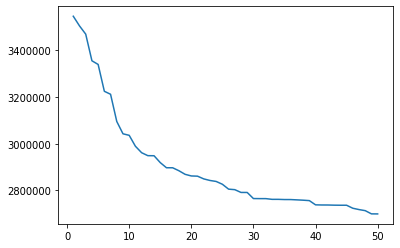

In [81]:
X_plot = [i for i in range(1, X.shape[1])]
Y_plot = []
for i in X_plot:
    pca_i = PCA(n_components=i)
    pca_i.fit(X, y)
    pca_i_X = pca_i.transform(X)
    reg_i = LinearRegression().fit(pca_i_X, y)
    Y_plot.append(np.mean((reg_i.predict(pca_i_X) - y)**2) ** 0.5)
plt.plot(X_plot, Y_plot)
    
# interact(plot, n_components=IntSlider(min=0, max=X.shape[1], continuous_update=False))

Fill out the cell below with your observations:

In [82]:
# Fill out this cell with observations #

### 2c. Canonical Correlation Analysis (CCA)

From the previous part, we saw that PCA is an unsupervised algorithm because it does not rely on feature labels, but rather focuses on the directions with the greatest variance in the feature matrix. However, there are some situations where the most relevant dimensions are not those with the greatest variance. For example, if the feature data was contaminated with a strong, correlated noise signal, PCA would actually throw away those dimensions with this strong noise variation, the opposite of our desired outcome. In this case, we prefer to approach dimensionality reduction in a way that takes advantage of paired, i.e labeled $(X, y)$ data. This is where CCA comes into play.

For this part, you will be using the <code>CCA</code> module from sklearn and create a model that is fitted to $X$ and $y$. 

Fill out the cells below using CCA along with linear regression to find the MSE of 2, 5, and 8 components. How does CCA perform compared to PCA with the same number of components? How does increasing the number of componetns affect the MSE? In general, CCA performs closely to linear regression. Why is that?

In [83]:
# CCA with 2 components #
# YOUR CODE HERE #

# Solution #
cca2 = CCA(n_components=2)
cca2.fit(X, y)
cca2_X = cca2.transform(X)
reg2 = LinearRegression().fit(cca2_X, y)
mse2 = np.mean((reg2.predict(cca2_X) - y)**2) ** 0.5
mse2
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2699272.5784772914

In [84]:
# CCA with 5 components #
# YOUR CODE HERE #

# Solution #
cca5 = CCA(n_components=5)
cca5.fit(X, y)
cca5_X = cca5.transform(X)
reg5 = LinearRegression().fit(cca5_X, y)
mse5 = np.mean((reg5.predict(cca5_X) - y)**2) ** 0.5
mse5
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2699272.578477292

In [85]:
# CCA with 8 components #
# YOUR CODE HERE #

# Solution #
cca8 = CCA(n_components=8)
cca8.fit(X, y)
cca8_X = cca5.transform(X)
reg8 = LinearRegression().fit(cca8_X, y)
mse8 = np.mean((reg8.predict(cca8_X) - y)**2) ** 0.5
mse8
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2699272.578477292

Fill out the cell below with your observations:

In [86]:
# Fill out this cell with observations #

## Part 3: Noisy Data

In the previous part, we saw observations from Linear Regression, PCA, and CCA on a dataset that has not been affected by noise. We will now observe what happens when our salary column has noise added to it, and how the accuracy of our predictions are affected by it.

First, run the cell below to generate noised predictions. The <code>utils.noised_predictions</code> is a black box function that will randomly add noise to our salary column using a random Gaussian.

In [87]:
y_noise = utils.noised_predictions(cleaned)
y_noise

0      9.004987e+06
2      2.086457e+06
4      4.740244e+05
5      1.402237e+06
6      4.536949e+05
           ...     
621    6.808602e+06
622    4.657536e+05
624    1.615241e+07
625    1.200202e+07
626    4.677895e+06
Name: salary, Length: 421, dtype: float64

### 3a. Noisy PCA

Use PCA with your noisy predictions and your original dataset. How does adding noise to the salary column change the MSE?

In [88]:
# PCA with 2 components #
# YOUR CODE HERE #

# Solution #
pca_noise2 = PCA(n_components=2)
pca_noise2.fit(X, y_noise)
pca_noise2_X = pca_noise2.transform(X)
reg_noise2 = LinearRegression().fit(pca_noise2_X, y_noise)
mse_noise2 = np.mean((reg_noise2.predict(pca_noise2_X) - y_noise)**2) ** 0.5
mse_noise2
# End solution #

3505926.9170889673

In [89]:
# PCA with 5 components #
# YOUR CODE HERE #

# Solution #
pca_noise5 = PCA(n_components=5)
pca_noise5.fit(X, y_noise)
pca_noise5_X = pca_noise5.transform(X)
reg_noise5 = LinearRegression().fit(pca_noise5_X, y_noise)
mse_noise5 = np.mean((reg_noise5.predict(pca_noise5_X) - y_noise)**2) ** 0.5
mse_noise5
# End solution #

3340121.9714894523

In [90]:
# PCA with 8 components #
# YOUR CODE HERE #

# Solution #
pca_noise8 = PCA(n_components=8)
pca_noise8.fit(X, y_noise)
pca_noise8_X = pca_noise8.transform(X)
reg_noise8 = LinearRegression().fit(pca_noise8_X, y_noise)
mse_noise8 = np.mean((reg_noise8.predict(pca_noise8_X) - y_noise)**2) ** 0.5
mse_noise8
# End solution #

3094664.193069675

Fill out the cell below with your observations:

In [91]:
# Fill out this cell with observations #

### 3b. Noisy CCA

Use PCA with your noisy predictions and your original dataset. How does adding noise to the salary column change the MSE?

In [92]:
# CCA with 2 components #
# YOUR CODE HERE #

# Solution #
cca_noise2 = CCA(n_components=2)
cca_noise2.fit(X, y_noise)
cca_noise2_X = cca_noise2.transform(X)
reg_noise2 = LinearRegression().fit(cca_noise2_X, y_noise)
mse_noise2 = np.mean((reg_noise2.predict(cca_noise2_X) - y_noise)**2) ** 0.5
mse_noise2
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2699771.306657605

In [93]:
# CCA with 5 components #
# YOUR CODE HERE #

# Solution #
cca_noise5 = CCA(n_components=2)
cca_noise5.fit(X, y_noise)
cca_noise5_X = cca_noise5.transform(X)
reg_noise5 = LinearRegression().fit(cca_noise5_X, y_noise)
mse_noise5 = np.mean((reg_noise5.predict(cca_noise5_X) - y_noise)**2) ** 0.5
mse_noise5
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2699771.306657605

In [94]:
# CCA with 8 components #
# YOUR CODE HERE #

# Solution #
cca_noise8 = CCA(n_components=2)
cca_noise8.fit(X, y_noise)
cca_noise8_X = cca_noise8.transform(X)
reg_noise8 = LinearRegression().fit(cca_noise8_X, y_noise)
mse_noise8 = np.mean((reg_noise2.predict(cca_noise8_X) - y_noise)**2) ** 0.5
mse_noise8
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2699771.306657605

Fill out the cell below with your observations:

In [95]:
# Fill out this cell with observations #

## Part 4: Dirty Data

You will now run the following cell in order to generate a "dirty" version of the above dataset. The function <code>dirty_data</code> is a black box function from the utils.py file that will alter the dataset in ways such as increasing the columns, adding strings, stringifying numbers, adding null values, etc. 

In [96]:
dirtied_data = utils.dirty_data(cleaned)

### 4a. Cleaning the dirty data

You will now need to clean this dirtied dataset. Fill out the cell below to clean the dataset so that it can be used for PCA and CCA. Hint: some useful methods can include using <code>dropna</code> and/or <code>astype</code>, fitering out rows with 0 or unknown salaries, and making sure all values are numbers, and not strings

In [97]:
# Solution #
dirtied_data = dirtied_data.dropna()
cols = dirtied_data.columns
for i in cols:
    dirtied_data[i] = dirtied_data[i].astype(float)
# End solution #

In order to make predictions, you will need to find the column that contains the salaries for the dirty data. Run the cell below to figure out which column name you will need to use. Then split the dirty data into a feature and prediction column.

In [98]:
dirtied_data.columns

Index([''chr'', 'g.y', '2B', 'sf', '12', '13', 'ch', 'LF', 'a', ''cbb'',
       'salary', '23', 'CF', ''bb'', 'SS', 'sh', ''SO'', 'gs', 'OF', 'PO',
       ''R'', 'ab', ''3B'', 'crbi', 'G.X', 'O2', ''x3b'', ''hbp'', 'GIDP',
       'DP', 'O3', 'cr', ''RF'', 'rbi', '2S', 'C', 'X2B', 'ibb', ''3S'', '1S',
       'CAB', 'SB', 'e', 'innouts', '1B', 'C1', 'CS', 'O1', ''years'', 'OC',
       'HR', 'H'],
      dtype='object')

In [99]:
salary = 'salary' # changes every time dirty_data is run
X_dirty = dirtied_data.drop(axis=1, columns=[salary])
y_dirty = dirtied_data[salary]

### 4b. Dirty PCA

Now run PCA on your dirty dataset, using 2, 5, and 8 components and find the MSE for your predictions. How does the performance compare to PCA of the original cleaned dataset?

In [100]:
# PCA with 2 components #
# YOUR CODE HERE #

# Solution #
pca_dirty2 = PCA(n_components=2)
pca_dirty2.fit(X_dirty, y_dirty)
pca_dirty2_X = pca_dirty2.transform(X_dirty)
reg_dirty2 = LinearRegression().fit(pca_dirty2_X, y_dirty)
mse_dirty2 = np.mean((reg_dirty2.predict(pca_dirty2_X) - y_dirty)**2) ** 0.5
mse_dirty2
# End solution #

3651656.437507077

In [101]:
# PCA with 5 components #
# YOUR CODE HERE #

# Solution #
pca_dirty5 = PCA(n_components=2)
pca_dirty5.fit(X_dirty, y_dirty)
pca_dirty5_X = pca_dirty5.transform(X_dirty)
reg_dirty5 = LinearRegression().fit(pca_dirty5_X, y_dirty)
mse_dirty5 = np.mean((reg_dirty5.predict(pca_dirty5_X) - y_dirty)**2) ** 0.5
mse_dirty5
# End solution #

3651656.437507077

In [102]:
# PCA with 8 components #
# YOUR CODE HERE #

# Solution #
pca_dirty8 = PCA(n_components=2)
pca_dirty8.fit(X_dirty, y_dirty)
pca_dirty8_X = pca_dirty8.transform(X_dirty)
reg_dirty8 = LinearRegression().fit(pca_dirty8_X, y_dirty)
mse_dirty8 = np.mean((reg_dirty8.predict(pca_dirty8_X) - y_dirty)**2) ** 0.5
mse_dirty8
# End solution #

3651656.437507077

Fill out the cell below with your observations:

In [103]:
# Fill out this cell with observations #

### 4c. Dirty CCA

Now run CCA on your dirty dataset, using 2, 5, and 8 components and find the MSE for your predictions. How does the performance compare to CCA of the original cleaned dataset?

In [104]:
# CCA with 2 components #
# YOUR CODE HERE #

# Solution #
cca_dirty2 = CCA(n_components=2)
cca_dirty2.fit(X_dirty, y_dirty)
cca_dirty2_X = cca_dirty2.transform(X_dirty)
reg_dirty2 = LinearRegression().fit(cca_dirty2_X, y_dirty)
mse_dirty2 = np.mean((reg_dirty2.predict(cca_dirty2_X) - y_dirty)**2) ** 0.5
mse_dirty2
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2780163.520656927

In [105]:
# CCA with 5 components #
# YOUR CODE HERE #

# Solution #
cca_dirty5 = CCA(n_components=5)
cca_dirty5.fit(X_dirty, y_dirty)
cca_dirty5_X = cca_dirty5.transform(X_dirty)
reg_dirty5 = LinearRegression().fit(cca_dirty5_X, y_dirty)
mse_dirty5 = np.mean((reg_dirty5.predict(cca_dirty5_X) - y_dirty)**2) ** 0.5
mse_dirty5
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2780163.5206569275

In [106]:
# CCA with 8 components #
# YOUR CODE HERE #

# Solution #
cca_dirty8 = CCA(n_components=2)
cca_dirty8.fit(X_dirty, y_dirty)
cca_dirty8_X = cca_dirty8.transform(X_dirty)
reg_dirty8 = LinearRegression().fit(cca_dirty8_X, y_dirty)
mse_dirty8 = np.mean((reg_dirty8.predict(cca_dirty8_X) - y_dirty)**2) ** 0.5
mse_dirty8
# End solution #

/Users/abhinavg/opt/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


2780163.520656927

Fill out the cell below with your observations:

In [107]:
# Fill out this cell with observations #